# SKTIME

https://www.sktime.net/en/v0.29.0/estimator_overview.html

sktime is a Python library for time series analysis. It provides a unified interface for multiple time series learning tasks, including time series classification, regression, clustering, annotation, and forecasting. sktime offers scikit-learn compatible interfaces and model composition tools, with the goal to make the ecosystem more usable and interoperable as a whole


python: "3.8"
build_dependencies:
  - pip
dependencies:
  - mlflow<3,>=2.1
  - sktime==0.16.0


# pyfunc

https://mlflow.org/docs/latest/python_api/mlflow.pyfunc.html

The python_function model flavor serves as a default model interface for MLflow Python models. Any MLflow Python model is expected to be loadable as a python_function model.

In [2]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

import pandas as pd
# set the experiment id
mlflow.set_tracking_uri("http://localhost:5000") 
experiment_name = "sktime"
try:
    mlflow.create_experiment(experiment_name)
except:
    print("experiment exists")
mlflow.set_experiment(experiment_name)

mlflow.sklearn.autolog(disable_for_unsupported_versions=True)

experiment exists


In [16]:
import json

import flavor
import pandas as pd
from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import matplotlib.pyplot as plt
import mlflow
ARTIFACT_PATH = "model"

In [18]:
y, X = load_longley()

In [19]:
X.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [24]:
len(X)

16

In [25]:
y

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
1952    63639.0
1953    64989.0
1954    63761.0
1955    66019.0
1956    67857.0
1957    68169.0
1958    66513.0
1959    68655.0
1960    69564.0
1961    69331.0
1962    70551.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [ ]:
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html

In [30]:
y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [31]:
y_train

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
1952    63639.0
1953    64989.0
1954    63761.0
1955    66019.0
1956    67857.0
1957    68169.0
1958    66513.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [32]:
y_test

Period
1959    68655.0
1960    69564.0
1961    69331.0
1962    70551.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

Parameters: 
{
  "sp": 1,
  "strategy": "last",
  "window_length": null
}
Metrics: 
{
  "mae": 3012.25,
  "mape": 0.04323478959579713
}


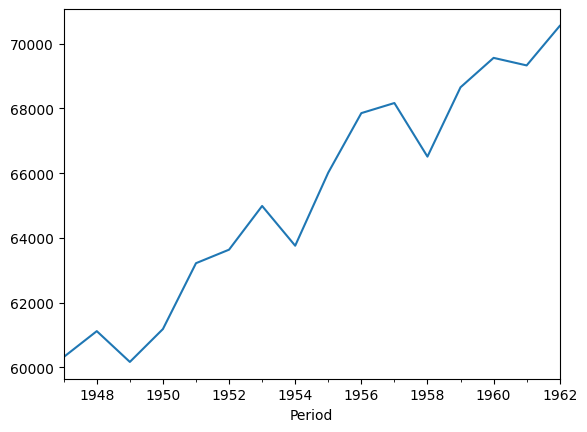

In [23]:
with mlflow.start_run() as run:
    y, X = load_longley()
    y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

    forecaster = NaiveForecaster()
    forecaster.fit(
        y_train,
        X=X_train,
    )

    # Extract parameters
    parameters = forecaster.get_params()

    # Evaluate model
    y_pred = forecaster.predict(fh=[1, 2, 3, 4], X=X_test)
    metrics = {
        "mae": mean_absolute_error(y_test, y_pred),
        "mape": mean_absolute_percentage_error(y_test, y_pred),
    }

    print(f"Parameters: \n{json.dumps(parameters, indent=2)}")
    print(f"Metrics: \n{json.dumps(metrics, indent=2)}")

    # Log parameters and metrics
    mlflow.log_params(parameters)
    mlflow.log_metrics(metrics)

    # Log model using custom model flavor with pickle serialization (default).
    # Note that pickle serialization requires using the same python environment
    # (version) in whatever environment you're going to use this model for
    # inference to ensure that the model will load with appropriate version of
    # pickle.
    flavor.log_model(
        sktime_model=forecaster,
        artifact_path=ARTIFACT_PATH,
        serialization_format="pickle",
    )
    model_uri = mlflow.get_artifact_uri(ARTIFACT_PATH)
    # mlflow tracking image
    fig, axs = plt.subplots(1)
    y.plot(ax=axs)
    mlflow.log_figure(fig, 'y.png')


In [27]:
model_uri

'file:///home/olonok/mlflow/mlruns/6/e3dda058ba9c492dae7bc2ec5ec29c54/artifacts/model'

In [28]:
# Load model in native sktime flavor and pyfunc flavor
loaded_model = flavor.load_model(model_uri=model_uri)
loaded_pyfunc = flavor.pyfunc.load_model(model_uri=model_uri)

# Convert test data to 2D numpy array so it can be passed to pyfunc predict using
# a single-row Pandas DataFrame configuration argument
X_test_array = X_test.to_numpy()

# Create configuration DataFrame for interval forecast with nominal coverage
# value [0.9,0.95], future forecast horizon of 4 periods, and exogenous regressor.
# Read more in the flavor.py module docstrings about the possible configurations.
predict_conf = pd.DataFrame(
    [
        {
            "fh": [1, 2, 3, 4],
            "predict_method": "predict_interval",
            "coverage": [0.9, 0.95],
            "X": X_test_array,
        }
    ]
)

# Generate interval forecasts with native sktime flavor and pyfunc flavor
print(
    f"\nNative sktime 'predict_interval':\n${loaded_model.predict_interval(fh=[1, 2, 3, 4], X=X_test, coverage=[0.9, 0.95])}"
)



Native sktime 'predict_interval':
$          Coverage                                          
              0.90                        0.95              
             lower         upper         lower         upper
1959  64211.598663  68814.401337  63770.711166  69255.288834
1960  63258.327017  69767.672983  62634.817940  70391.182060
1961  62526.855956  70499.144044  61763.216411  71262.783589
1962  61910.197326  71115.802674  61028.422333  71997.577667


In [29]:
print(f"\nPyfunc 'predict_interval':\n${loaded_pyfunc.predict(predict_conf)}")




Pyfunc 'predict_interval':
$      Coverage__0.9__lower  Coverage__0.9__upper  Coverage__0.95__lower  \
1959          64211.598663          68814.401337           63770.711166   
1960          63258.327017          69767.672983           62634.817940   
1961          62526.855956          70499.144044           61763.216411   
1962          61910.197326          71115.802674           61028.422333   

      Coverage__0.95__upper  
1959           69255.288834  
1960           70391.182060  
1961           71262.783589  
1962           71997.577667  


In [10]:
# Print the run id wich is used for serving the model to a local REST API endpoint
# in the score_model.py module
print(f"\nMLflow run id:\n{run.info.run_id}")
mlflow.end_run()


MLflow run id:
b525bc9936e8462cb3aa9a2ff0bc14ca


In [11]:
mlflow.end_run()